In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation

In [2]:
# finds the closest node from a certain position
def closest_node(position, nodes):
    diff = np.subtract(nodes, position)
    
    errors = np.sum(np.square(diff), axis = 1)
    closest = np.argmin(errors)
    
    return nodes[closest], closest

In [3]:
# Creates a Voronoi grid
#
# Returns a matrix of grid_resolution x grid_resolution. Each value 
# in this matrix refers to whichever node was closest to 
# that point on the grid. For example, all entries in the matrix
# whose value is 18 are a part of the same voronoi cell
def voronoi_mapping(grid_resolution, cell_count):  
    
    nodes = []
    random.seed(1373)
    for i in range(cell_count):
        # creates a node at a random location
        curr_x = random.random()
        curr_y = random.random()
        curr_node = (curr_x, curr_y)
        nodes.append(curr_node)
        
    # iterates over a square grid whose resolution is grid_resolution.
    # At each point in the grid, determines which node is closest
    axis = np.linspace(0, 1, grid_resolution, endpoint = False)
    voronoi_map = []
    for x in axis:
        temp_map = []
        for y in axis:
            curr_position = [x, y]
            voro_node, node_index = closest_node(curr_position, nodes)
            temp_map.append(node_index)
            
        voronoi_map.append(temp_map)
        
    return voronoi_map, nodes
            

In [4]:
# creates a dictionary of a cell's adjacencies
# For example, if cell 0 is adjacent to cell 4, 9, and 21,
# the entry adj_dict[0] would be equal to [4, 9, 21]
def gen_adj_dict(voronoi_map, nodes):
    grid_resolution = len(voronoi_map)
    cell_count = len(nodes)
    
    # each cell's adjacencies are stored in a set
    adj_dict = {i : set() for i in range(cell_count)}
    
    # iterates over the map in the y direction
    # detects when a change in cells occurs, and 
    # documents that as an adjacency
    prev = voronoi_map[0][0]
    for x in range(grid_resolution): # for every x value
        prev_node = voronoi_map[x][0]
        for y in range(grid_resolution): # iterates in the y direction
            curr_node = voronoi_map[x][y]
            if curr_node != prev_node: # detects changes in the closest node
                adj_dict[curr_node].add(prev_node)
                adj_dict[prev_node].add(curr_node)
            prev_node = curr_node
            
    for y in range(grid_resolution): # for every y value
        prev_node = voronoi_map[0][y]
        for x in range(grid_resolution): # iterates in the x direction
            curr_node = voronoi_map[x][y]
            if curr_node != prev_node: # detects changes in the closest node
                adj_dict[curr_node].add(prev_node)
                adj_dict[prev_node].add(curr_node)
            prev_node = curr_node
            
    return adj_dict

In [14]:
# Updates the plot for the current iteration, so that 
# the renderer knows what to animate
def update_plot(voronoi_map, node_state):
    grid_resolution = len(voronoi_map)
    plot_grid = np.zeros((grid_resolution, grid_resolution))
    
    for x in range(grid_resolution):
        for y in range(grid_resolution):
            curr_node = voronoi_map[x][y]
            plot_grid[x][y] = node_state[curr_node]
                
    return plot_grid

In [6]:
# plots the voronoi map for your viewing pleasure
def plot_voronoi(voronoi_map, grid_resolution):
    heatmap = np.empty((grid_resolution, grid_resolution))
    for x in range(grid_resolution):
        for y in range(grid_resolution):
            heatmap[x][y] = voronoi_map[x][y]
            
    plt.figure(figsize = (8,8))
    plt.imshow(heatmap, cmap = "RdBu")
    plt.show()

In [7]:
# Animation parameters!
#
# Some notes:
# - voronoi_mapping is horribly inefficient, and has 
#   O(grid_resolution^2 * cell_count)
#
# - A good number for cell_count is typically 1 - 6 times grid_resolution
#
# - grid_resolution should be greater than 100 to properly see the waves, but I
#   recommend using a value around 400 or more
#
# - because of the structure of the system, self-exciting loops can happen when 
#   the delay of one wave interferes with the propagation of the next! There's a 
#   list of parameters at the bottom of this cell you can try if you're interested.
#   Fun fact, this is the same mechanism that causes heart attacks.



grid_resolution = 400 # resolution of the grid across each axis
cell_count = 800 # the number of voronoi cells
delay = 5 # cooldown time of each cell
beat_rate = 25 # how often a new wave is initiated
seed_node = 0 # the starting cell


# Self-exciting loop parameters
# grid_resolution = 400
# cell_count = 800
# delay = 5
# beat_rate = 20
# seed_node = 0

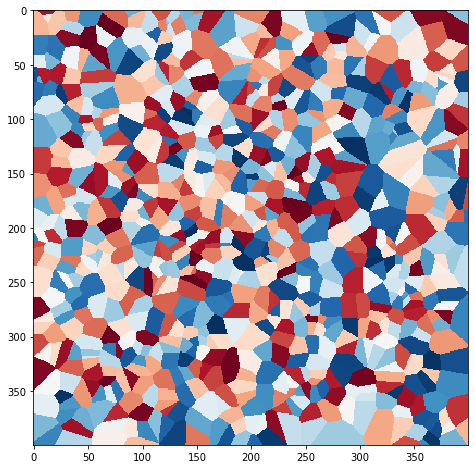

In [8]:
# this step can take a long time to run, so its in its own cell. Only run this
# if you have changed grid_resolution or cell_count
#
# For reference, with the default values of 400 and 800, this cell takes around 
# a minute to run on my computer
voronoi_map, nodes = voronoi_mapping(grid_resolution, cell_count)
adj_dict = gen_adj_dict(voronoi_map, nodes)
plot_voronoi(voronoi_map, grid_resolution)

In [23]:
#Please run this code then click play on the player. Set mode to loop to see it run multiple times. 
#It functions in JupyterLab but not on github. Please contact 
#akazmi30@gatech.edu if you need to see a demo. Thank you! 



#define states 
ON = 300 #on is burning. I set the value high so that on the output it appears red! 
BURNT = 200 
GROWING= 100
OFF = 25 #off= can be ignited

self_exciting = False

node_state_global = [OFF for i in range(cell_count)]

if self_exciting:
    random.seed(1311)
    random.random()
    random.random()
    beat_rate = 10
    
#As before, this function is what takes in one state and gives us the next 
def transition(data):
    global node_state_global# copy grid, similar to how we copied over the array in the 1D case
    #8 neighbors for calculation now! 
    node_state = node_state_global.copy()
        
    for i in range(cell_count):
        curr_state = node_state_global[i]
        if curr_state == ON:
            for neighbor in adj_dict[i]:
                if node_state[neighbor] == OFF:
                    node_state[neighbor] = ON
            node_state[i] = BURNT
        elif curr_state == BURNT:
            node_state[i] = GROWING
        elif curr_state == GROWING:
            node_state[i] = OFF
        
    if (data + 1) % beat_rate == 0:
        beat_node = int(random.random() * cell_count)
        node_state[beat_node] = ON
        
    # update data
    node_state_global = node_state
    plot_grid = update_plot(voronoi_map, node_state)
    mat.set_data(plot_grid)
    return mat

# set up animation
node_state_global[259] = ON
plot_grid = update_plot(voronoi_map, node_state_global)
fig, ax = plt.subplots(figsize = (6,6))
mat = ax.imshow(plot_grid, cmap = "summer")
ani = animation.FuncAnimation(fig, transition, interval=50,
                              save_count=100)

plt.close(fig)

#This code allows us to display the animation
#The animation has been tested to work in JupyterLab and Anaconda's Jupyter Notebooks

#When you first load the notebook you will need to run this cell (ctrl enter) to see the animation player. The image shown is the final state. 

#This will not display from within github.
from IPython.display import HTML
HTML(ani.to_jshtml())